# Thresholding Tests

In [1]:
import sys

import numpy as np
from scipy.interpolate import interp1d
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import astropy.units as u
import ndcube
from astropy.visualization import ImageNormalize, AsymmetricPercentileInterval, LogStretch, quantity_support
from astropy.coordinates import SkyCoord
import astropy.coordinates
import astropy.wcs
import sunpy.map
import sunpy.sun
import astropy.constants as const
from sunpy.coordinates.utils import get_limb_coordinates
import sunpy.map

from overlappy.io import read_overlappogram, write_overlappogram
from overlappy.util import strided_array, color_lat_lon_axes

sys.path.append('detector/')
from response import SpectrogramChannel

In [2]:
def get_full_overlappogram(components, order):
    data = np.array([components[k].data[0] for k in components]).sum(axis=0)
    wcs = components[order].wcs
    data_strided = strided_array(data, components[order].data.shape[0])
    return ndcube.NDCube(data_strided,
                         wcs=wcs,
                         unit=components[order].unit,
                         meta=components[order].meta)

In [3]:
def find_crossing(coord_a, coord_b, wavelength, wcs_1, wcs_3):
    pix_a3,_,_ = wcs_3.world_to_pixel(coord_a, wavelength)
    pix_b1,_,_ = wcs_1.world_to_pixel(coord_b, wavelength)
    i_cross = np.argwhere(np.diff(np.sign(pix_a3 - pix_b1))).squeeze()
    return wavelength[i_cross], pix_a3[i_cross]

In [4]:
def extract_along_coord_modified(smap, coord, wavelength):
    # Find pixels between each loop segment
    pz, px, py = smap.wcs.world_to_array_index(coord, wavelength)
    pix = []
    for i in range(len(px)-1):
        b = sunpy.map.maputils._bresenham(x1=px[i], y1=py[i], x2=px[i+1], y2=py[i+1])
        # Pop the last one, unless this is the final entry because the first point
        # of the next section will be the same
        if i < (len(px) - 2):
            b = b[:-1]
        pix.append(b)
    pix = np.vstack(pix)
        
    pix_z = np.array(pix.shape[0]*[pz[0]])

    intensity = u.Quantity(smap.data[pix_z, pix[:, 0], pix[:, 1]], smap.unit)
    coord_new,_ = smap.wcs.pixel_to_world(pix[:, 1], pix[:, 0], pix_z)

    return intensity, coord_new


In [5]:
overlappograms = {
    -3: read_overlappogram('output/overlappogram-active-region-order=-3.fits'),
    -1: read_overlappogram('output/overlappogram-active-region-order=-1.fits'),
    0: read_overlappogram('output/overlappogram-active-region-order=0.fits'),
    1: read_overlappogram('output/overlappogram-active-region-order=1.fits'),
    3: read_overlappogram('output/overlappogram-active-region-order=3.fits'),
}

In [6]:
total_overlap_order0 = get_full_overlappogram(overlappograms, 0)
total_overlap_order1 = get_full_overlappogram(overlappograms, 1)
total_overlap_order3 = get_full_overlappogram(overlappograms, 3)

In [7]:
wavelength_wcs = total_overlap_order0.axis_world_coords(0)[0]
wavelength = np.arange(1,100,0.055) * u.Angstrom

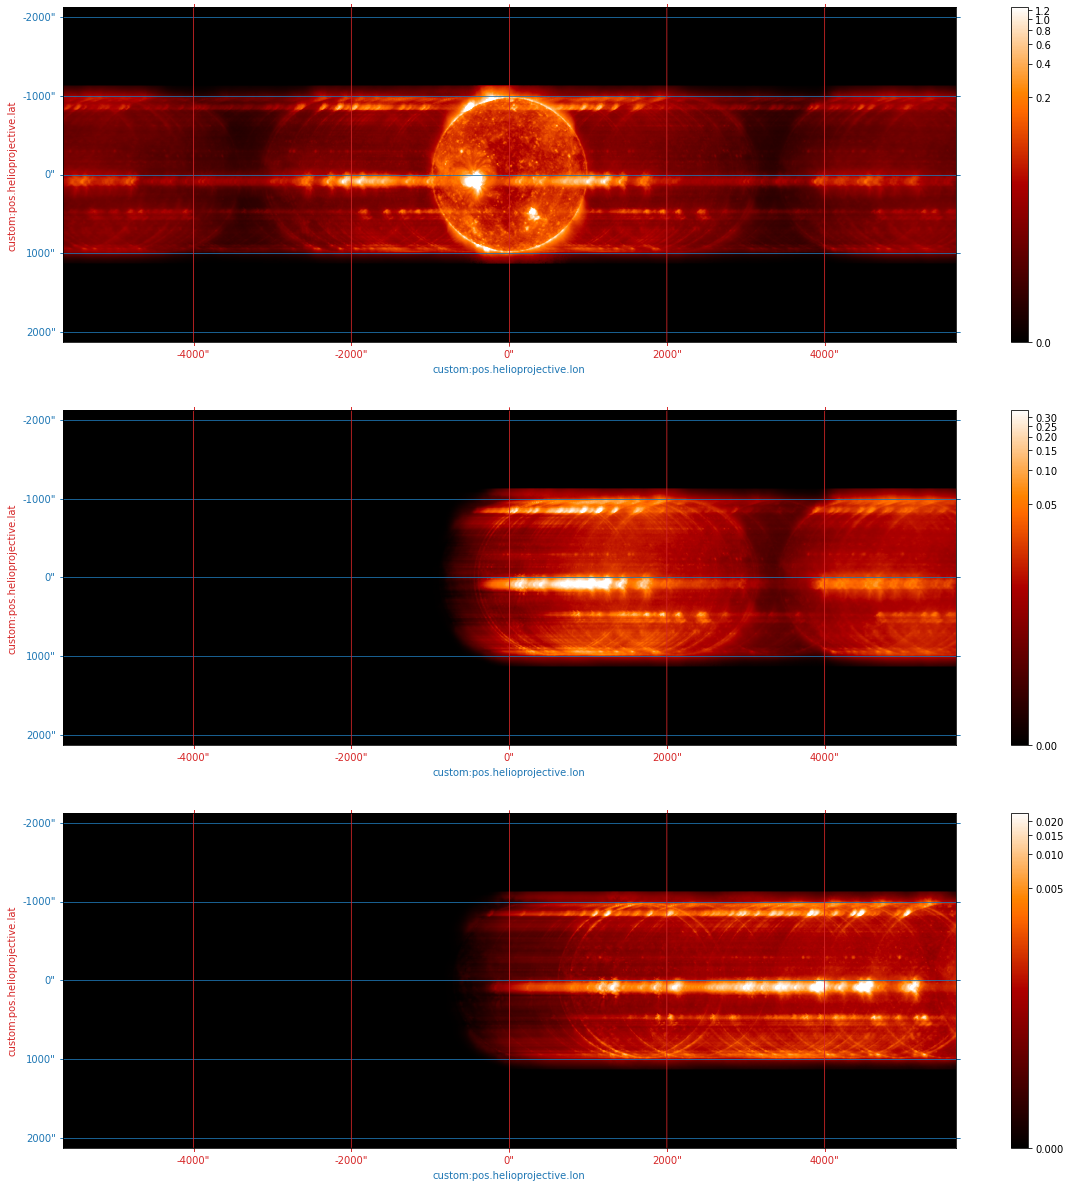

In [8]:
wave_index = 0
fig = plt.figure(figsize=(20,21))
for i,overlap in enumerate([total_overlap_order0, overlappograms[1], overlappograms[3]]):
    ax = fig.add_subplot(3,1,i+1, projection=overlap[wave_index].wcs)
    ## Plot
    plot_unit = 'ct / (pix s)'
    vmin, vmax = AsymmetricPercentileInterval(1,99.9).get_limits(
        u.Quantity(overlap[wave_index].data, overlap.unit).to_value(plot_unit),
    )
    overlap[wave_index].plot(
        axes=ax,
        cmap='hinodexrt',
        norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()),
        data_unit=plot_unit
    )
    color_lat_lon_axes(ax)
    plt.colorbar()

In [11]:
endpoints = SkyCoord(Tx=([100,100]*u.arcsec).to('deg'),
                     Ty=([-5600,5600]*u.arcsec).to('deg'),
                     frame=astropy.wcs.utils.wcs_to_celestial_frame(total_overlap_order1.wcs))

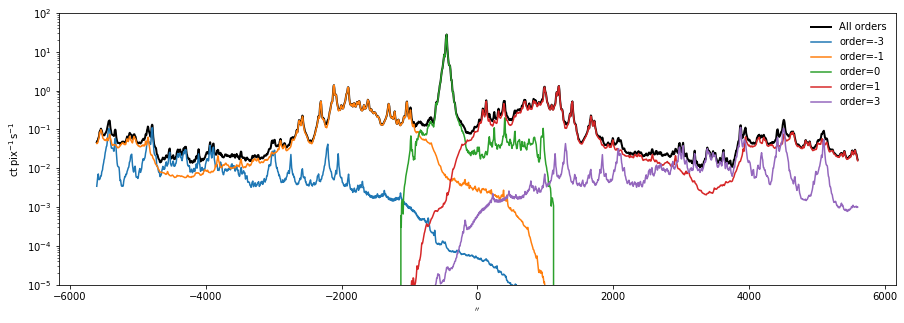

In [12]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
with quantity_support():
    # Combined
    intensity,intensity_coord = extract_along_coord_modified(total_overlap_order1, endpoints, wavelength_wcs[0])
    sep = intensity_coord.separation(intensity_coord[0])
    sep -= sep[sep.shape[0]//2]
    ax.plot(sep.to('arcsec'), intensity.to('ct pix-1 s-1'),color='k',lw=2,label='All orders')
    # other orders
    for k,cube in overlappograms.items():
        intensity,intensity_coord = extract_along_coord_modified(cube, endpoints, wavelength_wcs[0])
        sep = intensity_coord.separation(intensity_coord[0])
        sep -= sep[sep.shape[0]//2]
        ax.plot(sep.to('arcsec'), intensity.to('ct pix-1 s-1'), label=f'order={k}')
ax.set_yscale('log')
ax.set_ylim(1e-5,1e2)
ax.legend(frameon=False)
#fig.savefig('output/intensity-cut-qs.png', dpi=200)

In [13]:
hpc_frame = astropy.wcs.utils.wcs_to_celestial_frame(total_overlap_order0.wcs)

In [14]:
limb = get_limb_coordinates(hpc_frame.observer,resolution=500)
limb = SkyCoord(rho=limb.rho*1.2, psi=limb.psi, z=limb.z, frame=limb.frame)

In [15]:
half_b = limb[limb.psi<=180*u.deg].transform_to(hpc_frame)
half_a = SkyCoord(Tx=half_b.Tx, Ty=-half_b.Ty, distance=half_b.distance, frame=half_b.frame)

(<astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x7fccc4651d30>,
 <astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x7fccc465adc0>)

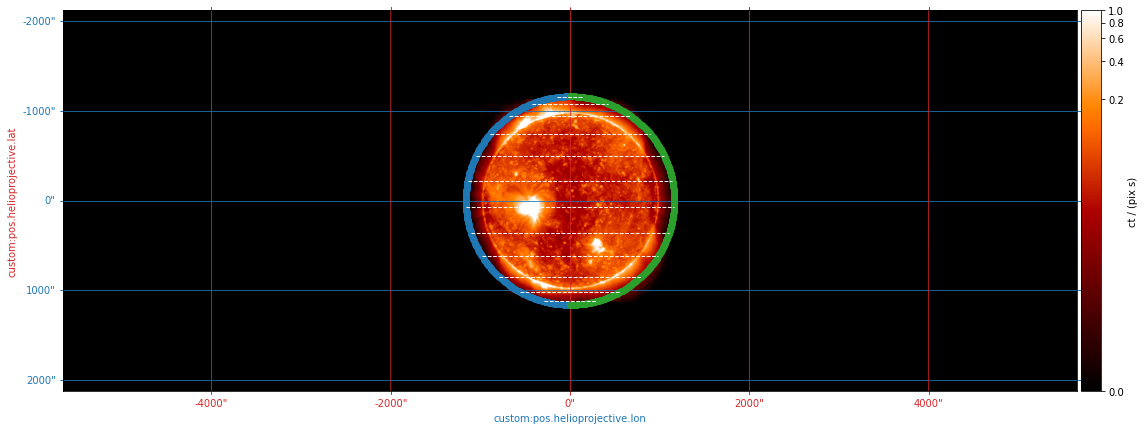

In [16]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111, projection=overlappograms[0][0].wcs)
plot_unit = 'ct / (pix s)'
overlappograms[0][0].plot(
    axes=ax,
    cmap='hinodexrt',
    norm=ImageNormalize(vmin=0,vmax=1,stretch=LogStretch()),
    data_unit=plot_unit
)
ax.plot_coord(half_a, ls='', marker='o',)
ax.plot_coord(half_b, ls='', marker='o',color='C2')
for a,b in zip(half_a[::20],half_b[::20]):
    ax.plot_coord(astropy.coordinates.concatenate((a,b)),color='w',lw=1,ls='--')
## Colorbar
im = ax.get_images()[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05, axes_class=matplotlib.axes.Axes)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position("right")
cbar.set_label(f'{plot_unit}',)
color_lat_lon_axes(ax)

In [17]:
chan1 = SpectrogramChannel(1, 'data/MOXSI_effarea.genx')
chan3 = SpectrogramChannel(3, 'data/MOXSI_effarea.genx')

In [18]:
dn = u.Quantity(interp1d(
    chan1.wavelength.to_value('Angstrom'),
    chan1.gain.to_value('ct / ph'),
    fill_value='extrapolate'
)(wavelength.to_value('Angstrom')), 'ct/ph') * 1 * u.ph 

In [19]:
dn1 = u.Quantity(interp1d(
    chan1.wavelength.to_value('Angstrom'),
    chan1.wavelength_response.to_value('cm2 ct / ph'),
    fill_value='extrapolate'
)(wavelength.to_value('Angstrom')), 'ct/ph') * 1 * u.ph / u.cm**2
dn3 = u.Quantity(interp1d(
    chan3.wavelength.to_value('Angstrom'),
    chan3.wavelength_response.to_value('cm2 ct / ph'),
    fill_value='extrapolate'
)(wavelength.to_value('Angstrom')), 'ct/ph') * 1 * u.ph / u.cm**2

In [20]:
pa_0, _, _ = total_overlap_order0.wcs.world_to_pixel(half_a[125], wavelength)
pa_1, _, _ = total_overlap_order1.wcs.world_to_pixel(half_a[125], wavelength)
pa_3, _, _ = total_overlap_order3.wcs.world_to_pixel(half_a[125], wavelength)
pb_0, _, _ = total_overlap_order0.wcs.world_to_pixel(half_b[125], wavelength)
pb_1, _, _ = total_overlap_order1.wcs.world_to_pixel(half_b[125], wavelength)
pb_3, _, _ = total_overlap_order3.wcs.world_to_pixel(half_b[125], wavelength)

(500.0, 2200.0)

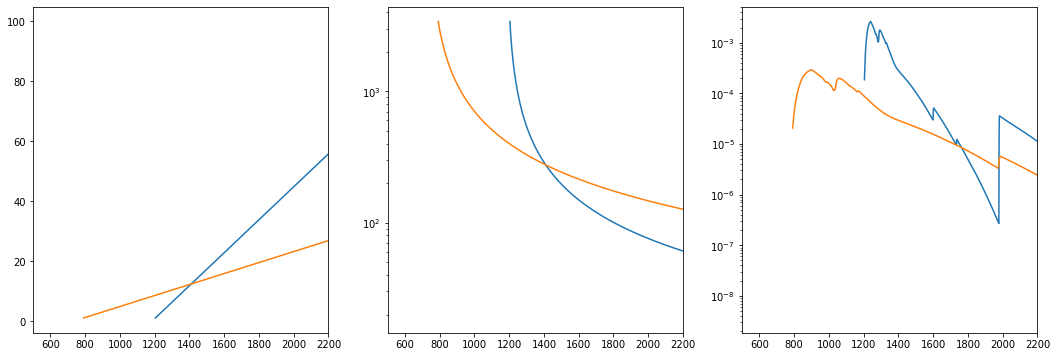

In [25]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.plot(pb_1, wavelength)
plt.plot(pa_3, wavelength)
plt.xlim(500,2200)
plt.subplot(132)
plt.plot(pb_1, dn)
plt.plot(pa_3, dn)
plt.yscale('log')
plt.xlim(500,2200)
plt.subplot(133)
plt.plot(pb_1, dn1)
plt.plot(pa_3, dn3)
#plt.ylim(1e-4,5e-3)
plt.yscale('log')
plt.xlim(500,2200)

In [26]:
wave_crossings,pix_crossings = [],[]
for a,b in zip(half_a,half_b):
    wp,pp = find_crossing(a, b, wavelength, total_overlap_order1.wcs, total_overlap_order3.wcs)
    wave_crossings.append(wp)
    pix_crossings.append(pp)
wave_crossings = u.Quantity(wave_crossings)
pix_crossings = np.array(pix_crossings)

In [28]:
dn_crossings = u.Quantity(interp1d(chan1.wavelength.to_value('Angstrom'), chan1.gain.to_value('ct / ph'),
                               fill_value='extrapolate')(wave_crossings.to_value('Angstrom')), 'ct/ph') * 1 * u.ph

In [55]:
i_coord = 125

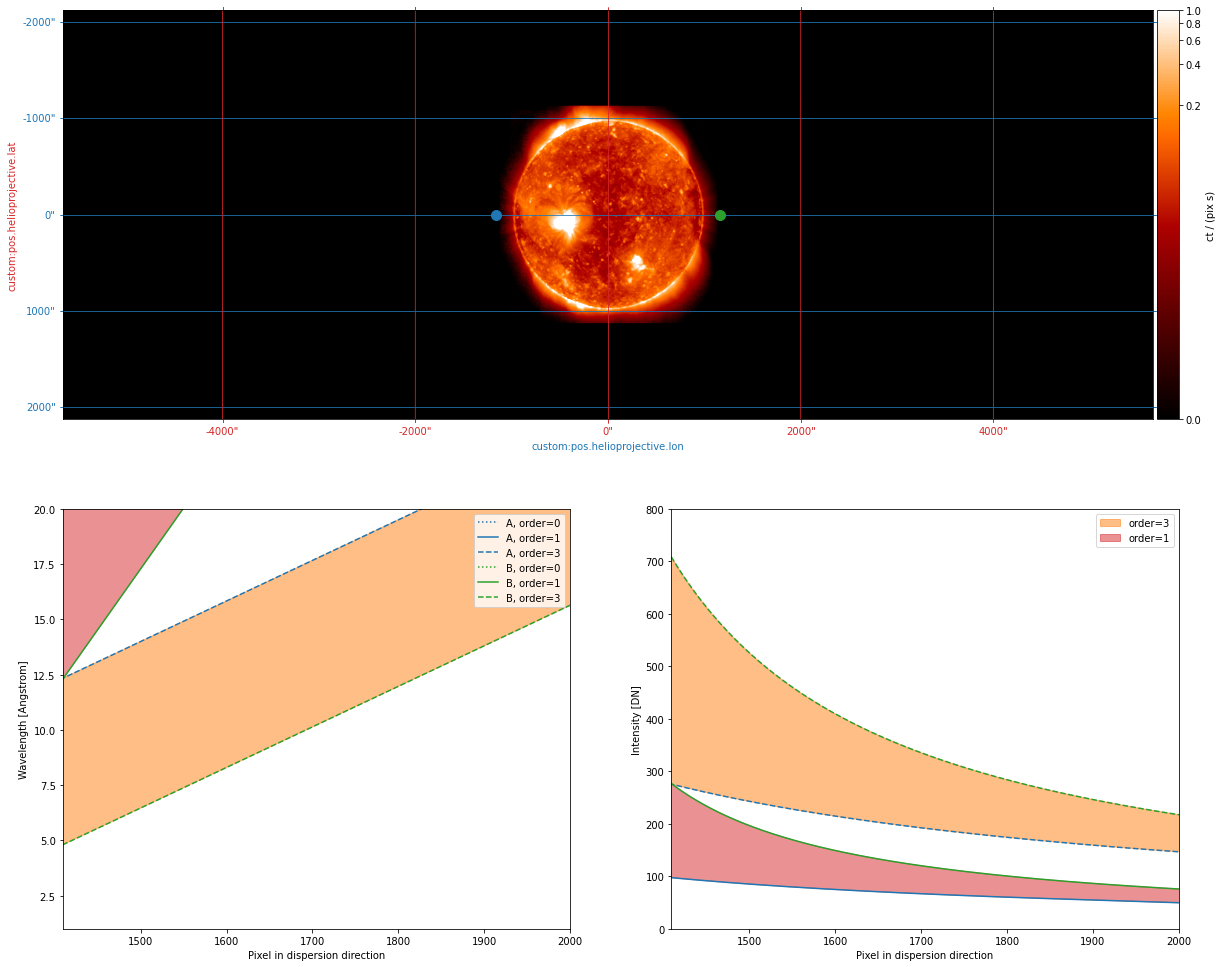

In [66]:
#for i_coord in range(len(half_a)):
# Get paths in pixel space across the detector
pa_0, _, _ = total_overlap_order0.wcs.world_to_pixel(half_a[i_coord], wavelength)
pa_1, _, _ = total_overlap_order1.wcs.world_to_pixel(half_a[i_coord], wavelength)
pa_3, _, _ = total_overlap_order3.wcs.world_to_pixel(half_a[i_coord], wavelength)
pb_0, _, _ = total_overlap_order0.wcs.world_to_pixel(half_b[i_coord], wavelength)
pb_1, _, _ = total_overlap_order1.wcs.world_to_pixel(half_b[i_coord], wavelength)
pb_3, _, _ = total_overlap_order3.wcs.world_to_pixel(half_b[i_coord], wavelength)

# Setup figure layout
fig = plt.figure(figsize=(20,17))
gs = GridSpec(2,2,figure=fig)
ax1 = fig.add_subplot(gs[0,:], projection=overlappograms[0][0].wcs)
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])

# overlappogram plot
plot_unit = 'ct / (pix s)'
overlappograms[0][0].plot(
    axes=ax1,
    cmap='hinodexrt',
    norm=ImageNormalize(vmin=0,vmax=1,stretch=LogStretch()),
    data_unit=plot_unit
)
ax1.plot_coord(half_a[i_coord], ls='', marker='o', markersize=10)
ax1.plot_coord(half_b[i_coord], ls='', marker='o',color='C2', markersize=10)
#ax1.plot_coord(astropy.coordinates.concatenate((half_a[i_coord],half_b[i_coord])),color='w',lw=1,ls='--')
## Colorbar
im = ax1.get_images()[0]
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='2%', pad=0.05, axes_class=matplotlib.axes.Axes)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position("right")
cbar.set_label(f'{plot_unit}',)
color_lat_lon_axes(ax1)

# Dispersion in wavelength space
ax2.plot(pa_0, wavelength.to('Angstrom'), color='C0', ls=':', label='A, order=0')
ax2.plot(pa_1, wavelength.to('Angstrom'), color='C0', ls='-', label='A, order=1')
ax2.plot(pa_3, wavelength.to('Angstrom'), color='C0', ls='--', label='A, order=3')
ax2.plot(pb_0, wavelength.to('Angstrom'), color='C2', ls=':', label='B, order=0')
ax2.plot(pb_1, wavelength.to('Angstrom'), color='C2', ls='-', label='B, order=1')
ax2.plot(pb_3, wavelength.to('Angstrom'), color='C2', ls='--', label='B, order=3')
# Fill bands
ax2.fill_betweenx(wavelength.to_value('Angstrom'), pb_3, pa_3, color='C1', alpha=0.5)
ax2.fill_betweenx(wavelength.to_value('Angstrom'), pb_1, pa_1, color='C3', alpha=0.5)
# #ax2.plot(pix_crossings[:i_coord+1],wave_crossings.to_value('Angstrom')[:i_coord+1],color='C4')
# ax2.axvline(pix_crossings[i_coord],color='k',ls='--')
#ax2.plot(pix_crossings[i_coord],wave_crossings.to_value('Angstrom')[i_coord],
#         marker='o',color='C4',markersize=10)
# ax2.fill_betweenx(wavelength.to_value('Angstrom'),pix_crossings[i_coord],pa_0,
#                   color='k', alpha=0.25)
# Limits / labels
ax2.set_xlim(pix_crossings[i_coord],2000)
ax2.set_ylim(wavelength[0].to_value('Angstrom'),20)
ax2.set_ylabel('Wavelength [Angstrom]')
ax2.set_xlabel('Pixel in dispersion direction')
ax2.legend()

# Dispersion in energy space
ax3.plot(pa_0, dn.to('ct'), color='C0', ls=':', )#label='A, order=0')
ax3.plot(pa_1, dn.to('ct'), color='C0', ls='-', )#label='A, order=1')
ax3.plot(pa_3, dn.to('ct'), color='C0', ls='--', )#label='A, order=3')
ax3.plot(pb_0, dn.to('ct'), color='C2', ls=':', )#label='B, order=0')
ax3.plot(pb_1, dn.to('ct'), color='C2', ls='-', )#label='B, order=1')
ax3.plot(pb_3, dn.to('ct'), color='C2', ls='--', )#label='B, order=3')
# Fill bands
# ax3.axvline(pix_crossings[i_coord],color='k',ls='--')
ax3.fill_betweenx(dn.to_value('ct'), pb_3, pa_3, color='C1', alpha=0.5,label='order=3')
ax3.fill_betweenx(dn.to_value('ct'), pb_1, pa_1, color='C3', alpha=0.5,label='order=1')
# #ax3.plot(pix_crossings[:i_coord+1],dn_crossings.to_value('ct')[:i_coord+1],color='C4')
#ax3.plot(pix_crossings[i_coord],dn_crossings.to_value('ct')[i_coord],
#         marker='o',color='C4',markersize=10)
# ax3.fill_betweenx(dn.to_value('ct'),pix_crossings[i_coord],pa_0,
#                   color='k', alpha=0.25)
# Limits / labels
ax3.set_xlim(pix_crossings[i_coord],2000)
ax3.set_ylim(0,800)#dn[0].to_value('ct'))
ax3.set_ylabel('Intensity [DN]')
ax3.set_xlabel('Pixel in dispersion direction')
ax3.legend()
#fig.savefig(f'gif_figures/separation-animation-{i_coord:06d}.png')
#plt.close(fig=fig)

In [30]:
pxa_limb, pya_limb, _ = total_overlap_order0.wcs.world_to_pixel(half_a,wavelength[0])
pxb_limb, pyb_limb, _ = total_overlap_order0.wcs.world_to_pixel(half_b,wavelength[0])

In [31]:
py_col = np.arange(0,750,1,dtype=int)

In [32]:
pxa_col = np.interp(py_col, pya_limb, pxa_limb, )
pxb_col = np.interp(py_col, pyb_limb, pxb_limb, )

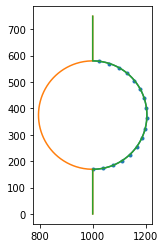

In [33]:
fig = plt.figure()
ax = fig.gca()
ax.plot(pxb_limb, pyb_limb, marker='.',markevery=15)
ax.plot(pxa_col, py_col)
ax.plot(pxb_col, py_col)
ax.set_aspect('equal')

In [34]:
cut_coord_a,_ = total_overlap_order0.wcs.pixel_to_world(pxa_col, py_col, 0)
cut_coord_b,_ = total_overlap_order0.wcs.pixel_to_world(pxb_col, py_col, 0)

In [35]:
wc_col,pc_col = [],[]
for a,b in zip(cut_coord_a, cut_coord_b):
    wp,pp = find_crossing(a, b, wavelength, total_overlap_order1.wcs, total_overlap_order3.wcs)
    wc_col.append(wp)
    pc_col.append(pp)
wc_col = u.Quantity(wc_col)
pc_col = np.array(pc_col)

In [36]:
cutoff,_ = total_overlap_order0.wcs.pixel_to_world(pc_col, py_col, 0)

(<astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x7fcb97631430>,
 <astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x7fcb38db3670>)

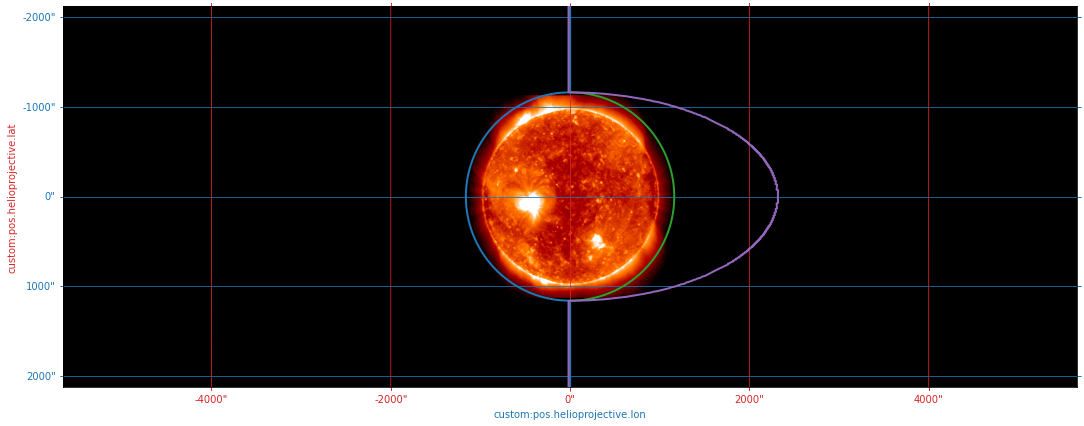

In [67]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111, projection=overlappograms[0][0].wcs)
plot_unit = 'ct / (pix s)'
overlappograms[0][0].plot(
    axes=ax,
    cmap='hinodexrt',
    norm=ImageNormalize(vmin=0,vmax=1,stretch=LogStretch()),
    data_unit=plot_unit
)
ax.plot_coord(cut_coord_b,color='C2',lw=2,)
ax.plot_coord(cut_coord_a,color='C0',lw=2)
ax.plot_coord(cutoff, color='C4', lw=2)
color_lat_lon_axes(ax)

(<astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x7fcbc1c1e670>,
 <astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x7fcc11fd2ca0>)

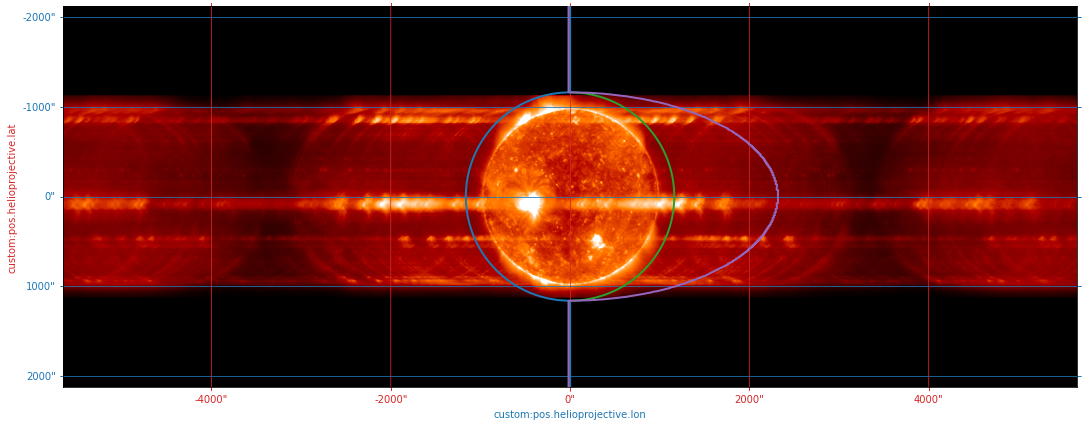

In [68]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111, projection=total_overlap_order0[0].wcs)
plot_unit = 'ct / (pix s)'
total_overlap_order0[0].plot(
    axes=ax,
    cmap='hinodexrt',
    norm=ImageNormalize(vmin=0,vmax=1,stretch=LogStretch()),
    data_unit=plot_unit
)
ax.plot_coord(cut_coord_b,color='C2',lw=2)
ax.plot_coord(cut_coord_a,color='C0',lw=2)
ax.plot_coord(cutoff, color='C4', lw=2)
color_lat_lon_axes(ax)

In [38]:
px_row = np.arange(0,total_overlap_order0.data.shape[2],1)

In [39]:
upper_limit_o1_map = []
for cc,pc in zip(cut_coord_b, pc_col):
    # Find pixel coordinate of the disk extent edge dispersed across the detector
    # As a function of wavelength
    px_b1,_,_ = total_overlap_order1.wcs.world_to_pixel(cc, wavelength)
    # Interpolate the 1st order upper energy cutoff to the actual pixel position across the detector
    ul = np.interp(px_row, px_b1, dn, left=0, right=0)
    # Impose cutoff at critical point below which no separation can be made
    ul = np.where(px_row<pc, 0, ul)
    upper_limit_o1_map.append(ul)
upper_limit_o1_map = np.stack(upper_limit_o1_map)

In [40]:
upper_limit_o1_map = ndcube.NDCube(upper_limit_o1_map, wcs=total_overlap_order0[0].wcs, unit=dn.unit)

In [53]:
upper_limit_o1_cube.data.shape

(1073, 750, 2000)

In [50]:
upper_limit_o1_cube = ndcube.NDCube(strided_array(upper_limit_o1_map.data, total_overlap_order0.data.shape[0],),
              wcs=total_overlap_order0[0].wcs,
              unit=dn.unit)

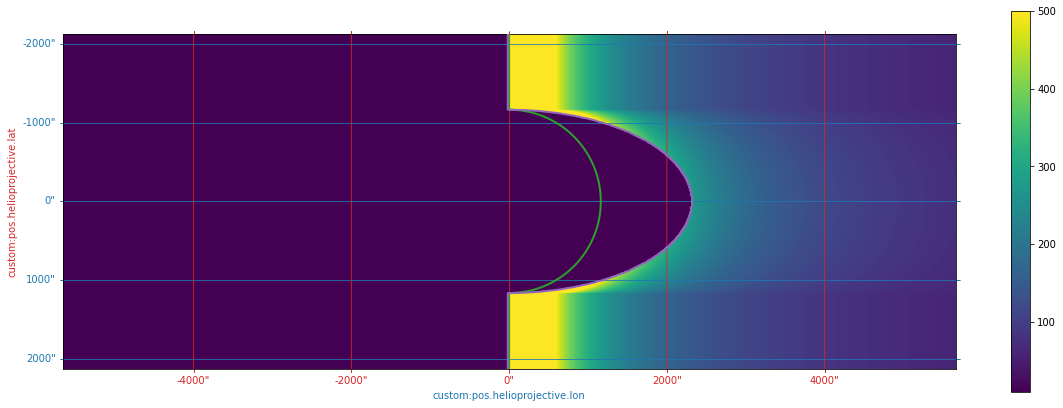

In [60]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111, projection=upper_limit_o1_map.wcs)
#plot_unit = 'ct / (pix s)'
upper_limit_o1_map.plot(
    axes=ax,
    #cmap='hinodexrt',
    norm=ImageNormalize(vmin=10, vmax=500,)#stretch=LogStretch()),
    #data_unit=plot_unit
)
ax.plot_coord(cut_coord_b,color='C2',lw=2)
#ax.plot_coord(cut_coord_a,color='C2',lw=2)
ax.plot_coord(cutoff, color='C4', lw=2, ls='-')
color_lat_lon_axes(ax)
plt.colorbar()

ValueError: Number of world inputs (2) does not match expected (1)

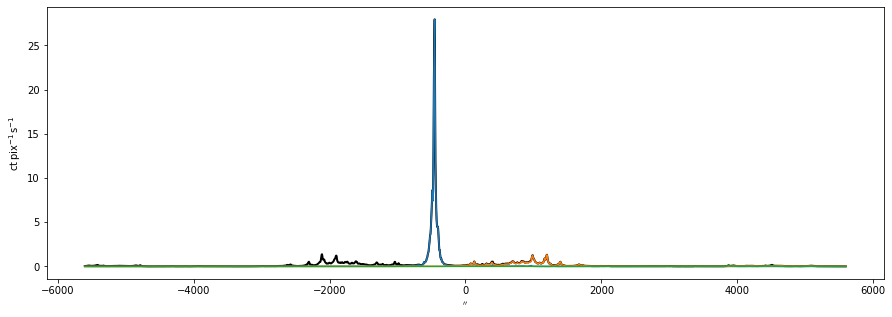

In [51]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
with quantity_support():
    # Combined
    intensity,intensity_coord = extract_along_coord_modified(total_overlap_order1, endpoints, wavelength_wcs[0])
    sep = intensity_coord.separation(intensity_coord[0])
    sep -= sep[sep.shape[0]//2]
    ax.plot(sep.to('arcsec'), intensity.to('ct pix-1 s-1'),color='k',lw=2,label='All orders')
    # other orders
    for k in [0, 1, 3]:
        cube = overlappograms[k]
        intensity,intensity_coord = extract_along_coord_modified(cube, endpoints, wavelength_wcs[0])
        sep = intensity_coord.separation(intensity_coord[0])
        sep -= sep[sep.shape[0]//2]
        ax.plot(sep.to('arcsec'), intensity.to('ct pix-1 s-1'), label=f'order={k}')
    # Limit
    ul,ul_coord = extract_along_coord_modified(upper_limit_o1_cube, endpoints, wavelength_wcs[0])
    sep = ul_coord.separation(ul_coord[0])
    sep -= sep[sep.shape[0]//2]
    ax.plot(sep.to('arcsec'), ul.to('ct')/u.Unit('pix s'), label=f'Upper limit')
ax.set_yscale('log')
ax.set_ylim(1e-5,1e2)
ax.legend(frameon=False)
#fig.savefig('output/intensity-cut-qs.png', dpi=200)

## Sandbox

Text(0.5, 1.0, 'order=3')

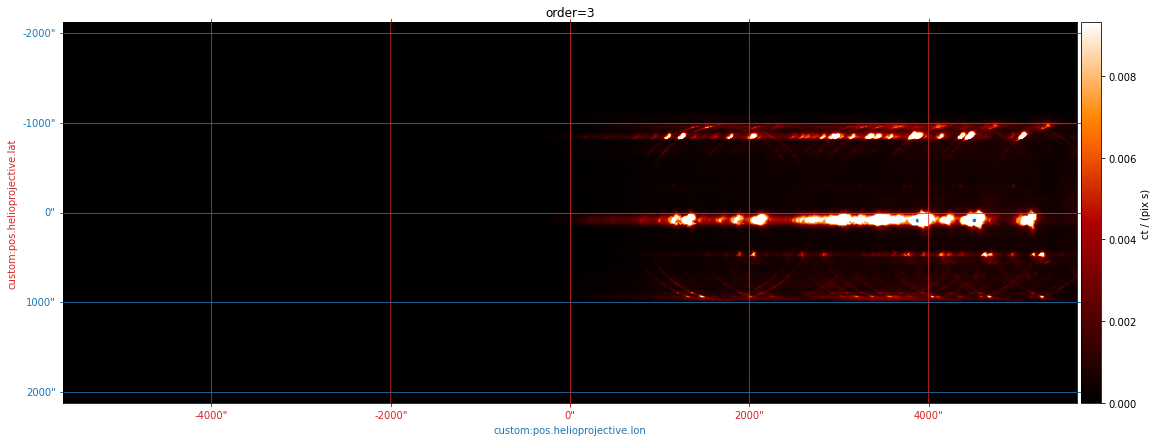

In [6]:
wave_index = 0
selected_overlappogram = overlappograms[3]
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111, projection=selected_overlappogram[wave_index].wcs)
## Plot
plot_unit = 'ct / (pix s)'
vmin, vmax = AsymmetricPercentileInterval(1,99.5).get_limits(
    u.Quantity(selected_overlappogram[wave_index].data, 
               selected_overlappogram.unit).to_value(plot_unit),
)
selected_overlappogram[wave_index].plot(
    axes=ax,
    cmap='hinodexrt',
    norm=ImageNormalize(vmin=vmin,vmax=vmax,),
    data_unit=plot_unit
)
## Contours
contour_args = {#'cmap': 'viridis',
                'colors': ['C0', 'C4']}
levels = [0.1, 1.0] * u.Unit('ct / (pix s)')
y, x = np.indices(selected_overlappogram[wave_index].data.shape)
cs = ax.contour(x, y, selected_overlappogram[wave_index].data,
                levels.to_value(plot_unit), 
                **contour_args)
ax.clabel(cs, cs.levels, inline=True, fontsize=10)
## Colorbar
im = ax.get_images()[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05, axes_class=matplotlib.axes.Axes)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position("right")
cbar.set_label(f'{plot_unit}',)
color_lat_lon_axes(ax)
ax.set_title(f'order=3')

In [7]:
def make_binary_map(cube, thresh):
    bool_data = u.Quantity(cube.data[0], cube.unit) > thresh
    return ndcube.NDCube(strided_array(bool_data, cube.data.shape[0]),
                         wcs=cube.wcs, meta=cube.meta, unit=None)

Text(0.5, 1.0, 'if data > 1 DN / pix s')

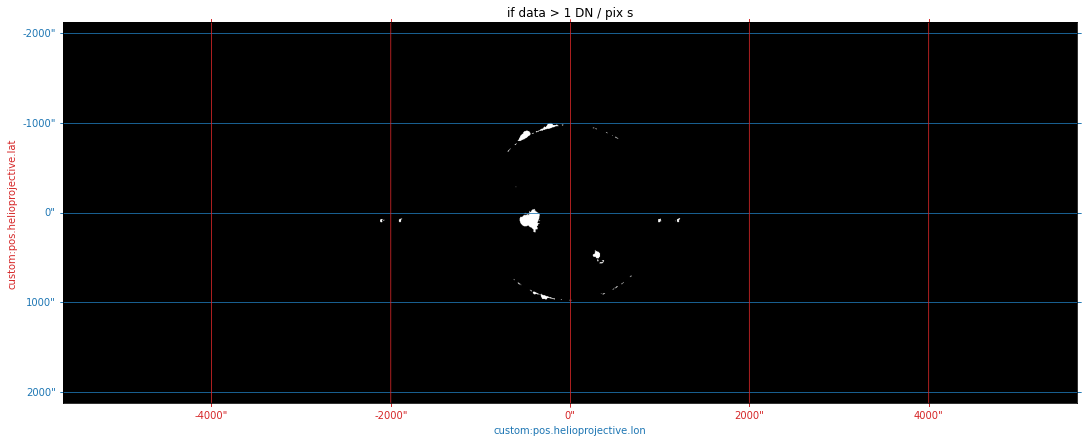

In [8]:
wave_index = 0
selected_overlappogram = make_binary_map(total_overlap_order0, 1.0*u.ct/u.pix/u.s)
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111, projection=selected_overlappogram[wave_index].wcs)
## Plot
selected_overlappogram[wave_index].plot(
    axes=ax,
    cmap='Greys_r',
    norm=ImageNormalize(vmin=0,vmax=1),
)
color_lat_lon_axes(ax)
ax.set_title(f'if data > 1 DN / pix s')